
# Introduction: Alzheimer_classification Kaggle problem
 ***This is the code based on the course: [Deep Learning with PyTorch: Zero to GANs](https://jovian.ai/aakashns/collections/deep-learning-with-pytorch)*** \

In the above tutorial [Aakash Rao N S](https://jovian.ai/aakashns) applied his code for the [CIFAR10 data set](https://www.cs.toronto.edu/~kriz/cifar.html). 

With this project, I do the imgage classification with a [Kaggle MRI with 4 classes data set](https://www.kaggle.com/datasets/tourist55/alzheimers-dataset-4-class-of-images)

NOTE that Aakash does not do the image transformation with his tutorial, tt.Compose. 

I here, I would like to test the testing accuracy using **Resnet34**, when
- Doing no image transformation
- Doing image transformation using torchvision.transforms
- Doing image transformation using monai.transform

## About Dataset
The data consists of MRI images. The data has four classes (from most healthy to leas healthy) of images both in training as well as a testing set:

NOD: Non Demented \
VMD: Very Mild Demented \
MID: Mild Demented \
MOD: Moderate Demented 

NOTE: WHEN I DO THE RESTNET34 WITH NO TRANSFORMATION. I OBSERVED THAT THE EVALUATE ON THE TEST SET HAS REALLY LOW ACCURACY COMPARED WITH THE EVALUATE ON THE VALIDATION SET. \
`The first thing that I observe is that the test set has images seem to be really different from the train and validation set. I think this is why the image registration comes in handy. \
In here, I just first process a naive way that I just mix the images in the train and test set. Then split them into train, validation and test set. The purpose of this way is to see if the accuracy on the test set would be similar to the 
accuracy on the validation set if the test set is similar with the validation set.`

## Kaggle reference:
- [https://www.kaggle.com/code/darthmanav/alzheimer-s-classification-resnet-50](https://www.kaggle.com/code/darthmanav/alzheimer-s-classification-resnet-50)

- [https://www.kaggle.com/code/kenconstable/alzheimer-s-multi-class-classification](https://www.kaggle.com/code/kenconstable/alzheimer-s-multi-class-classification)

In [1]:
import os
import torch
import torchvision
# from torchvision.datasets.utils import download_url
from torch.utils.data import random_split
import pandas as pd
from torchvision.datasets import ImageFolder
from torchvision.transforms import ToTensor
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import torch.nn as nn
import torch.nn.functional as F
import glob
import cv2
import torchvision.transforms as tt

In [3]:
from mymodule import *

# S1. Explore the data

## Overall exploration 

Get the *original* subfolder and classes

In [5]:
data_dir = './Data/org_dat'
subfolders = os.listdir(data_dir) # list the subfolder in the main folder 
print("Subfolder in the data folder: ", subfolders) 
classes = os.listdir(data_dir + "/" + subfolders[1]) # get the class from the train folder 
print("The classes avaiable in each subfolder:", classes)

Subfolder in the data folder:  ['test', 'train']
The classes avaiable in each subfolder: ['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']


Get the number of images in each subfolder

In [6]:
df = num_files_f(data_dir)
print(df)

      MildDemented ModerateDemented NonDemented VeryMildDemented
test           179               12         640              448
train          717               52        2560             1792


Check the images' sizes

In [9]:
find_min_max_img_size(data_img_dir="./Data/ori_dat/train/VeryMildDemented/*.jpg")

ValueError: min() arg is an empty sequence

## Combine the two folders (./Data/train and ./Data/test) to a single folder (./Data/all) 

As I observe before that the test set of this data seems to be too different from the train data. This will make the model gotten from training from the train data could not work well with the test data. 

I will try to combine the train and test folder to create a new folder named `all` that contain all of the subclasses and images then read and split them into (new) train, validation, and testing set 

In [ ]:
# import shutil 
# data_dir = './Data'
# # Source directions
# train_dir = data_dir + '/train'
# test_dir = data_dir + '/test'
# # Destination direction
# dst_dir = data_dir + '/all' # we dont create the all_files folder, the shutil automatically creates the folder for us.
# # copy all files and folder from the train folder to the `all` folder
# shutil.copytree(src = train_dir, dst = dst_dir)

In [ ]:
# # Now, consider each folder in the test_dir, 
# # take the file name of each file in that folder and copy to the associative folder in the dst_dir
# for folder in os.listdir(test_dir):
#     # print(test_dir+'/'+ folder + "/*/jpg")
#     # print(dst_dir + '/' + folder)
#     files = os.listdir(test_dir+'/'+ folder)
#     for file in files:
#         shutil.copy(src = test_dir+'/'+ folder + '/'+ file, dst = dst_dir + '/' + folder)

## Read all of the subclasses and images from the `all` folder then split them into train, val, and test set

Load the data as a Pytorch tensors (with NO image transformation)

In [ ]:
dat_all = ImageFolder(data_dir+'/all', transform=ToTensor())
print(len(dat_all)), print(dat_all.classes), print(dat_all.classes[0])

6400
['MildDemented', 'ModerateDemented', 'NonDemented', 'VeryMildDemented']
MildDemented


(None, None, None)

Label:  MildDemented (0)


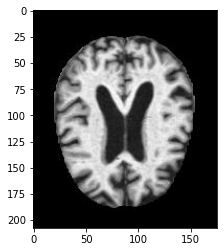

In [ ]:
show_example(dat_all, 0)

Label:  MildDemented (0)


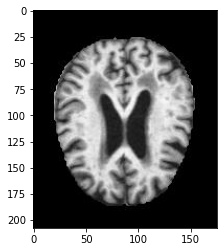

In [ ]:
show_example(dat_all,80)

Label:  VeryMildDemented (3)


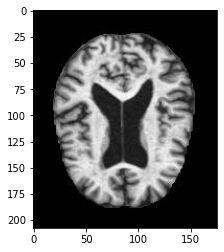

In [ ]:
show_example(dat_all,5000)

Split into train + val + test

In [ ]:
random_seed = 42
torch.manual_seed(random_seed)
#
train_size = int(0.7 * len(dat_all))
val_size = int(0.2 * len(dat_all))
test_size = len(dat_all) - train_size - val_size
#
trainset, valset, testset = torch.utils.data.random_split(dat_all, [train_size, val_size, test_size])

In [ ]:
print(len(trainset))
print(len(valset))
print(len(testset))

4480
1280
640


In [ ]:
testset

In [ ]:
len(testset.indices)

640

In [ ]:
trainset.dataset

Dataset ImageFolder
    Number of datapoints: 6400
    Root location: ./Data/all
    StandardTransform
Transform: ToTensor()

In [ ]:
testset.dataset

Dataset ImageFolder
    Number of datapoints: 6400
    Root location: ./Data/all
    StandardTransform
Transform: ToTensor()

In [ ]:
show_example(testset,630)

AttributeError: 'Subset' object has no attribute 'classes'

In [ ]:
?trainset

Type:        Subset
String form: <torch.utils.data.dataset.Subset object at 0x0000027759E63550>
Length:      4480
File:        c:\users\tranl\miniconda3\envs\pytorch\lib\site-packages\torch\utils\data\dataset.py
Docstring:  
Subset of a dataset at specified indices.

Args:
    dataset (Dataset): The whole Dataset
    indices (sequence): Indices in the whole set selected for subset


In [ ]:
testset.indices

[393,
 347,
 1583,
 5151,
 5571,
 3022,
 6050,
 2333,
 4466,
 4277,
 3903,
 4904,
 335,
 938,
 2253,
 5612,
 5400,
 4257,
 1588,
 4291,
 2496,
 6083,
 4742,
 4130,
 611,
 1095,
 2479,
 5161,
 1792,
 714,
 3455,
 973,
 3424,
 1550,
 4849,
 5092,
 1741,
 3683,
 1018,
 6015,
 1060,
 3080,
 3294,
 2077,
 263,
 3454,
 2230,
 1770,
 533,
 2284,
 5230,
 6366,
 5664,
 4416,
 1266,
 3458,
 2767,
 2650,
 2367,
 1655,
 1923,
 1141,
 2572,
 3389,
 3948,
 1444,
 2876,
 2647,
 2510,
 4967,
 2437,
 4187,
 5934,
 4218,
 4504,
 740,
 5825,
 1027,
 1940,
 3696,
 2962,
 5537,
 4022,
 2653,
 1384,
 1116,
 155,
 3320,
 497,
 3096,
 2713,
 3417,
 1602,
 2996,
 4542,
 5338,
 4782,
 3437,
 1369,
 3131,
 5843,
 2154,
 2055,
 4094,
 932,
 4966,
 1224,
 2348,
 3811,
 2568,
 1302,
 6270,
 663,
 3093,
 6148,
 6202,
 1716,
 812,
 1680,
 3926,
 2174,
 4364,
 2637,
 4764,
 4185,
 2086,
 5956,
 1083,
 6292,
 5989,
 3159,
 1051,
 6276,
 3001,
 1597,
 4342,
 2612,
 2913,
 4444,
 3347,
 1702,
 869,
 4140,
 2725,
 5076,
 

Create data loader

In [ ]:
from torch.utils.data.dataloader import DataLoader
batch_size = 32 # start with a smaller number, like, 16, 32, then keep doubling the batchs_ize, and check the training time
#
train_dl = DataLoader(trainset, batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_dl = DataLoader(valset, 
                    batch_size*2, #the valid-batch_size = 2*training-batch_size since we dont need to compute the gradient
                    num_workers=4, pin_memory=True)

In [ ]:
train_dl.

Draw a batch 

tensor([2, 2, 3, 3, 2, 2, 2, 3, 3, 3, 3, 1, 2, 0, 2, 2, 3, 3, 3, 2, 3, 1, 2, 3,
        2, 3, 2, 0, 0, 2, 2, 0])


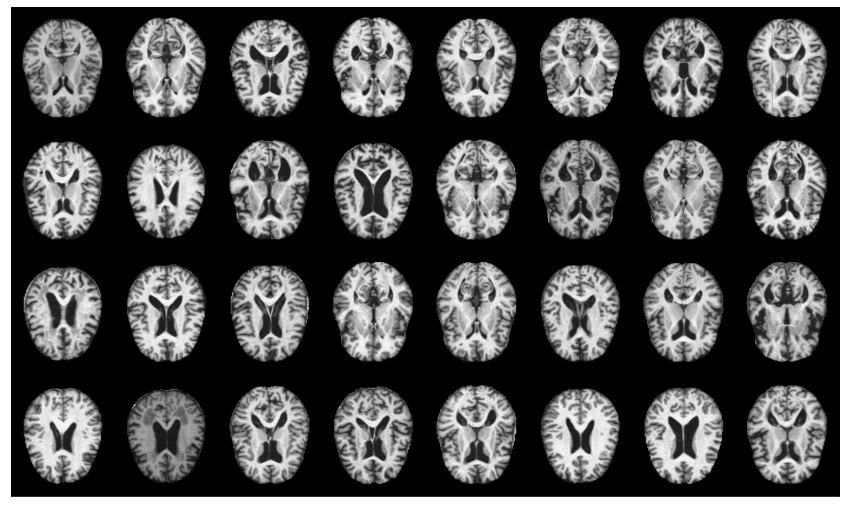

In [ ]:
show_batch(train_dl)

tensor([0, 2, 3, 3, 1, 2, 2, 2, 3, 0, 0, 0, 2, 2, 3, 2, 0, 3, 0, 0, 2, 2, 2, 2,
        2, 3, 2, 2, 2, 2, 2, 2, 2, 2, 3, 2, 2, 3, 2, 2, 2, 2, 2, 3, 2, 0, 3, 2,
        1, 3, 0, 3, 3, 3, 3, 3, 2, 2, 1, 0, 3, 3, 2, 3])


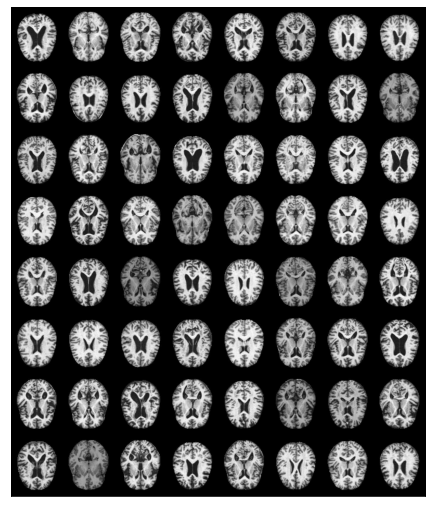

In [ ]:
show_batch(val_dl)

# S2 Define model

In [ ]:
from torchvision import models

class Resnet34_No_Transform_model(ImageClassificationBase):
    def __init__(self, num_classes, pretrained=False):
        super().__init__()
        # Use a pretrained model
        self.network = models.resnet34(pretrained=pretrained)
        # Replace last layer
        self.network.fc = nn.Linear(self.network.fc.in_features, num_classes)

    def forward(self, xb):
        return self.network(xb)
    

In [ ]:
device = get_default_device()
device

device(type='cuda')

In [ ]:
train_dl = DeviceDataLoader(train_dl, device)
val_dl = DeviceDataLoader(val_dl, device)

# S3. Train Model

In [ ]:
model = Resnet34_No_Transform_model(len(classes), pretrained=False)
to_device(model, device);

In [ ]:
model

Resnet34_No_Transform_model(
  (network): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layer1): Sequential(
      (0): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (relu): ReLU(inplace=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
      (1): BasicBlock(
        (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, af

In [ ]:
# check if our model works
# history = [evaluate(model, val_dl)]
# history

In [ ]:
%%time
epochs = 70
lr = 0.001
opt_func = torch.optim.Adam
history = fit(epochs, lr , model, train_dl, val_dl, opt_func=opt_func)

  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [0], train_loss: 0.9613, val_loss: 1.5679, val_acc: 0.3641


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [1], train_loss: 0.8008, val_loss: 2.7371, val_acc: 0.4977


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [2], train_loss: 0.6985, val_loss: 0.6599, val_acc: 0.7008


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [3], train_loss: 0.4812, val_loss: 0.5217, val_acc: 0.8094


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [4], train_loss: 0.3698, val_loss: 0.3199, val_acc: 0.8727


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [5], train_loss: 0.2583, val_loss: 0.8089, val_acc: 0.7609


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [6], train_loss: 0.1803, val_loss: 0.5563, val_acc: 0.8133


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [7], train_loss: 0.1354, val_loss: 0.1389, val_acc: 0.9492


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [8], train_loss: 0.0769, val_loss: 0.3938, val_acc: 0.8523


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [9], train_loss: 0.0768, val_loss: 0.8227, val_acc: 0.7766


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [10], train_loss: 0.0926, val_loss: 0.1025, val_acc: 0.9633


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [11], train_loss: 0.0548, val_loss: 0.2077, val_acc: 0.9187


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [12], train_loss: 0.0663, val_loss: 0.3036, val_acc: 0.9070


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [13], train_loss: 0.0541, val_loss: 0.2627, val_acc: 0.9148


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [14], train_loss: 0.0493, val_loss: 0.1452, val_acc: 0.9523


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [15], train_loss: 0.0392, val_loss: 0.2399, val_acc: 0.9297


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [16], train_loss: 0.0270, val_loss: 0.1985, val_acc: 0.9461


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [17], train_loss: 0.0325, val_loss: 0.1239, val_acc: 0.9531


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [18], train_loss: 0.0359, val_loss: 0.2665, val_acc: 0.9258


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [19], train_loss: 0.0394, val_loss: 0.1495, val_acc: 0.9539


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [20], train_loss: 0.0868, val_loss: 0.1498, val_acc: 0.9492


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [21], train_loss: 0.0295, val_loss: 0.1128, val_acc: 0.9680


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [22], train_loss: 0.0073, val_loss: 0.0415, val_acc: 0.9859


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [23], train_loss: 0.0080, val_loss: 0.1170, val_acc: 0.9617


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [24], train_loss: 0.0319, val_loss: 0.2297, val_acc: 0.9336


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [25], train_loss: 0.1086, val_loss: 0.3271, val_acc: 0.9086


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [26], train_loss: 0.0256, val_loss: 0.0648, val_acc: 0.9766


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [27], train_loss: 0.0093, val_loss: 0.1043, val_acc: 0.9695


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [28], train_loss: 0.0218, val_loss: 0.1255, val_acc: 0.9586


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [29], train_loss: 0.0293, val_loss: 0.0633, val_acc: 0.9820


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [30], train_loss: 0.0099, val_loss: 0.0983, val_acc: 0.9711


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [31], train_loss: 0.0140, val_loss: 0.1330, val_acc: 0.9617


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [32], train_loss: 0.0446, val_loss: 0.1425, val_acc: 0.9625


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [33], train_loss: 0.0316, val_loss: 0.0706, val_acc: 0.9797


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [34], train_loss: 0.0198, val_loss: 0.1204, val_acc: 0.9641


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [35], train_loss: 0.0348, val_loss: 0.2405, val_acc: 0.9383


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [36], train_loss: 0.0187, val_loss: 0.0710, val_acc: 0.9820


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [37], train_loss: 0.0198, val_loss: 0.1096, val_acc: 0.9727


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [38], train_loss: 0.0215, val_loss: 0.0837, val_acc: 0.9766


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [39], train_loss: 0.0105, val_loss: 0.1052, val_acc: 0.9758


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [40], train_loss: 0.0123, val_loss: 0.2092, val_acc: 0.9438


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [41], train_loss: 0.0246, val_loss: 0.0796, val_acc: 0.9703


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [42], train_loss: 0.0330, val_loss: 0.1585, val_acc: 0.9539


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [43], train_loss: 0.0172, val_loss: 0.1355, val_acc: 0.9648


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [44], train_loss: 0.0119, val_loss: 0.0794, val_acc: 0.9773


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [45], train_loss: 0.0226, val_loss: 0.4072, val_acc: 0.9117


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [46], train_loss: 0.0320, val_loss: 0.1012, val_acc: 0.9734


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [47], train_loss: 0.0155, val_loss: 0.1161, val_acc: 0.9656


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [48], train_loss: 0.0098, val_loss: 0.0945, val_acc: 0.9789


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [49], train_loss: 0.0022, val_loss: 0.0616, val_acc: 0.9844


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [50], train_loss: 0.0015, val_loss: 0.0629, val_acc: 0.9852


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [51], train_loss: 0.0005, val_loss: 0.0501, val_acc: 0.9875


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [52], train_loss: 0.0002, val_loss: 0.0394, val_acc: 0.9906


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [53], train_loss: 0.0001, val_loss: 0.0391, val_acc: 0.9914


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [54], train_loss: 0.0001, val_loss: 0.0407, val_acc: 0.9867


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [55], train_loss: 0.0000, val_loss: 0.0395, val_acc: 0.9898


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [56], train_loss: 0.0001, val_loss: 0.0408, val_acc: 0.9898


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [57], train_loss: 0.0000, val_loss: 0.0373, val_acc: 0.9898


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [58], train_loss: 0.0000, val_loss: 0.0433, val_acc: 0.9906


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [59], train_loss: 0.0000, val_loss: 0.0368, val_acc: 0.9906


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [60], train_loss: 0.0000, val_loss: 0.0409, val_acc: 0.9914


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [61], train_loss: 0.0000, val_loss: 0.0393, val_acc: 0.9898


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [62], train_loss: 0.0000, val_loss: 0.0383, val_acc: 0.9883


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [63], train_loss: 0.0000, val_loss: 0.0390, val_acc: 0.9898


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [64], train_loss: 0.0000, val_loss: 0.0380, val_acc: 0.9906


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [65], train_loss: 0.0000, val_loss: 0.0400, val_acc: 0.9914


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [66], train_loss: 0.0000, val_loss: 0.0350, val_acc: 0.9922


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [67], train_loss: 0.0000, val_loss: 0.0423, val_acc: 0.9906


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [68], train_loss: 0.0000, val_loss: 0.0363, val_acc: 0.9906


  0%|          | 0/140 [00:00<?, ?it/s]

Epoch [69], train_loss: 0.0000, val_loss: 0.0343, val_acc: 0.9922
CPU times: total: 6min 29s
Wall time: 23min 38s


# S4. Plot train+validation history

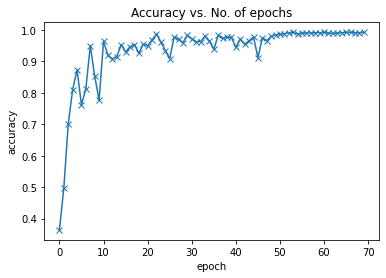

In [ ]:
plot_accuracies(history)

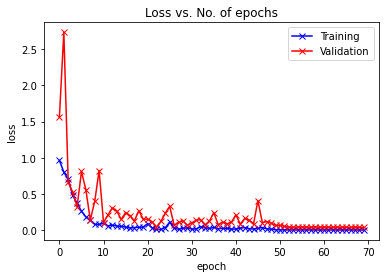

In [32]:
plot_losses(history)

# S5. Save model


In [33]:
torch.save(model.state_dict(), './model/Resnet34_alldata_No_Transform_cnn.pth')

# S6 Prediction Testing_Accuracy

In [17]:
Resnet34_alldata_No_Transform_trainedmodel = to_device(Resnet34_No_Transform_model(4), device)  #  redefine the model with the same structure of the MRIModel
Resnet34_alldata_No_Transform_trainedmodel.load_state_dict(torch.load('./model/Resnet34_alldata_No_Transform_cnn.pth'))

<All keys matched successfully>

Let's define a helper function `predict_image`, which returns the predicted label for a single image tensor.

In [21]:
def predict_image(img, model, dataset, device):
    # Convert to a batch of 1
    xb = to_device(img.unsqueeze(0), device)
    # Get predictions from model
    yb = model(xb)
    # Pick index with highest probability
    _, preds  = torch.max(yb, dim=1)
    # Retrieve the class label
    return dataset.classes[preds[0].item()]

In [ ]:
test

AttributeError: 'Subset' object has no attribute 'classes'

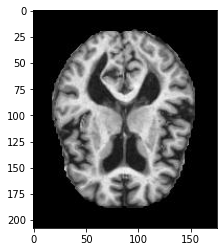

In [22]:
img, label = testset[0]
plt.imshow(img.permute(1, 2, 0).clamp(0, 1))
print('Label:', testset.classes[label], ', Predicted:', predict_image(img, model, testset, device))

In [16]:
test_loader = DeviceDataLoader(DataLoader(testset, batch_size*2), device)
result = evaluate(Resnet34_alldata_No_Transform_trainedmodel, test_loader)
result

{'val_loss': 0.030259806662797928, 'val_acc': 0.9937499761581421}

Create confusion matrix

In [24]:
testset.dataset[1500]

(tensor([[[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]],
 
         [[0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          ...,
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.],
          [0., 0., 0.,  ..., 0., 0., 0.]]]),
 2)